In [1]:
import os
import sys
sys.path.append(os.path.abspath('../'))


import numpy as np
from tqdm import tqdm
from scipy.linalg import qr
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import linregress
from scipy.stats import expon, geom
from scipy.optimize import curve_fit
from concurrent.futures import ProcessPoolExecutor, as_completed

from src.solvers import solve_lorenz
from src.utils.metrics import Metrics as m
from src.utils.generators import generate_pairs_of_initial_states

# The Lorentz system overview

Defining the system

Consider $x = (x, y,z)$:

$$ 
\begin{gather*}
\dot{x} = \sigma(y - x)\\ 
\dot{y} = x(\rho - z) - y \\ 
\dot{z} = xy - \beta z
\end{gather*}
$$

the Lorenz system, which has long been used for studying the interplay between predictability and chaos. We select with $\beta = 8/3$ and $\sigma = 10$ standard parameter settings, retaining $\rho$ as the bifurcation parameter.

![](lorenz_attractor.gif)

In [ ]:
# Parameters
dr = 0.003125
r_values = np.arange(180, 183, dr)
dt = 0.001
t_span = (0, 150)
# Initial state
initial_state = np.array([1.0, 1.0, 1.0], dtype=np.float64)

# Solve the system
res = solve_lorenz(r_values, t_span, dt, initial_state, if_ode = True, method = 'LSODA')


In [6]:
vals_list = []
control_param_list = []
save_bif = 0

for i, r in enumerate(r_values):
    cpl, vl = m.poincare_section(
        trajectory=res['trajectories'][i],
        control_param=r,
        dim=2,
        mode="min"
    )
    vals_list.extend(vl)
    control_param_list.extend(cpl)

if save_bif:
    np.savetxt("../outputs/bif_z_min.dat", np.vstack((control_param_list, vals_list)).T)



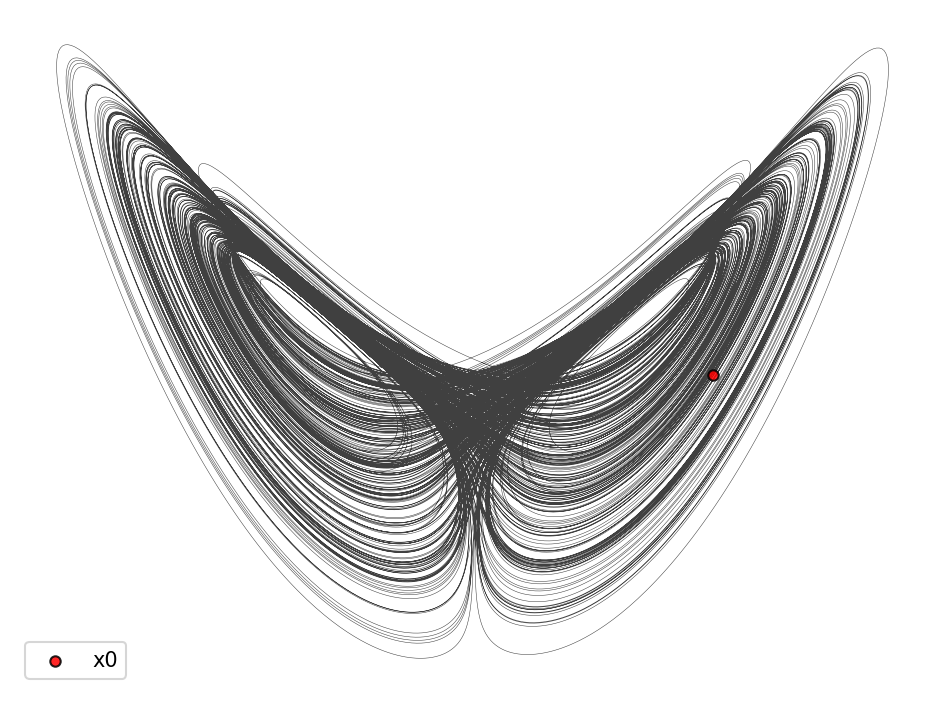

In [20]:
fig, ax = plt.subplots(1,dpi=150)
ax.plot(res['trajectories'][i][:,0], res['trajectories'][i][:,2], lw = .25, c = "k", alpha = .75)
ax.scatter(res['trajectories'][i][0,0], res['trajectories'][i][0,2], c ='r', ec = 'k', s = 25, zorder = 10, label = "x0", alpha = .85)
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.axis("off")
plt.legend()
plt.tight_layout()
plt.show()

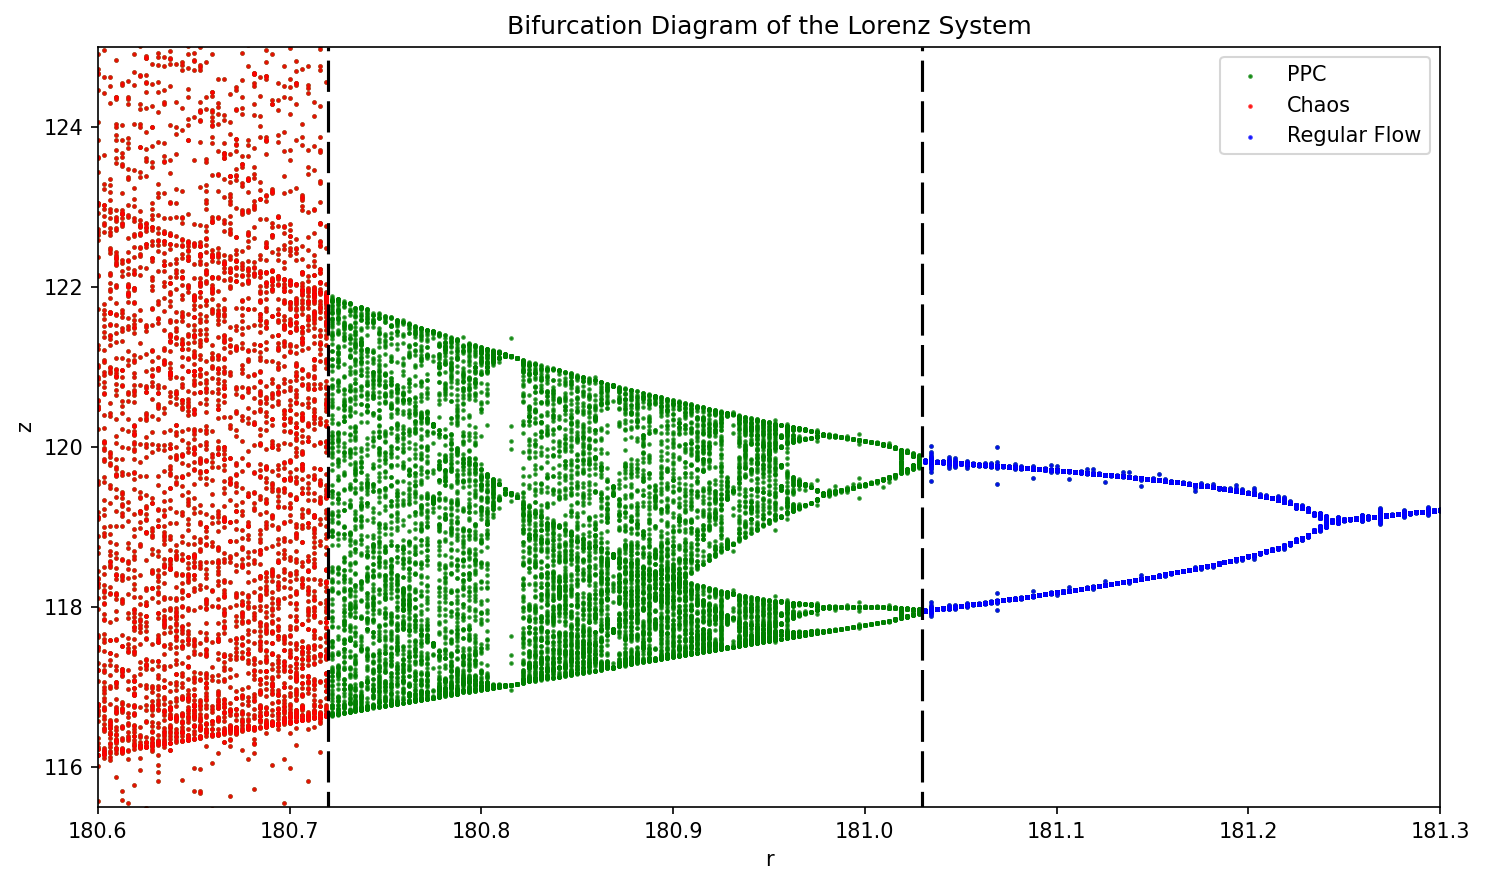

In [5]:
# Plot the results
load_bif = 1

if load_bif:
    control_param_list, vals_list = np.loadtxt("../outputs/bif_z_min.dat", unpack=True)
plt.figure(figsize=(10, 6), dpi=150)

mask1 = control_param_list <= 180.72
mask2 = control_param_list >= 181.03
plt.scatter(control_param_list, vals_list, color='green', s=1.5, label='PPC', alpha = 0.75)
plt.scatter(control_param_list[mask1], vals_list[mask1], color='red', s=1.5, label='Chaos', alpha = 0.75)
plt.scatter(control_param_list[mask2], vals_list[mask2], color='blue', s=1.5, label='Regular Flow', alpha = 0.75)
plt.axvline(x=181.03, color='k', ls = (5, (10, 3)))
plt.axvline(x=180.72, color='k', ls = (5, (10, 3)))

plt.xlabel('r')
plt.ylabel('z')
plt.title('Bifurcation Diagram of the Lorenz System')
plt.legend()
plt.xlim(180.6, 181.3)
plt.ylim(115.5,125)
plt.tight_layout()
# plt.savefig("../figs/bif_diagram.png", dpi = 150)
plt.show()

In [16]:
# Parameters
r_values_spec = (180.7, 180.78, 181.03, 181.15)
dt = 0.001
t_span = (0, 150)
# Initial state
initial_state = np.array([1.0, 1.0, 1.0], dtype=np.float64)

# Solve the system
res = solve_lorenz(r_values_spec, t_span, dt, initial_state, if_ode = True, method = 'LSODA')


100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


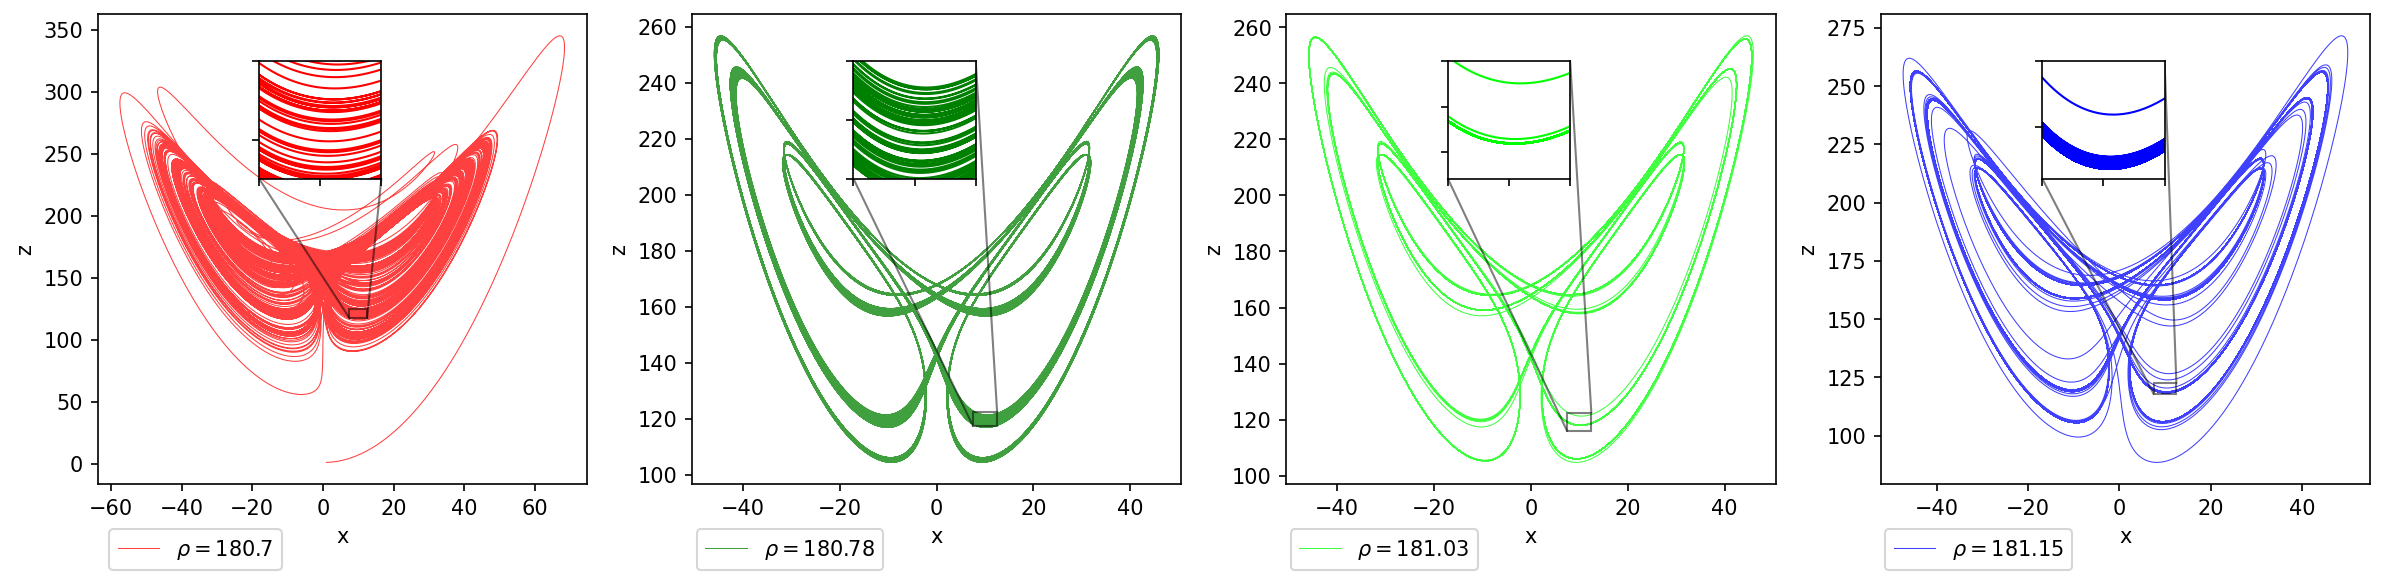

In [46]:
fig, ax = plt.subplots(1,4, figsize = (16,4), dpi=150)

colors = ['r', 'g', 'lime', 'b']

x1s = [7.5, 7.5, 7.5, 7.5]
x2s = [12.5, 12.5, 12.5, 12.5]
y1s = [117.5,117.5, 116., 118]
y2s = [125,122.5, 122.5, 122.5]

for i in range(4):
    ax[i].plot(res['trajectories'][i][:,0], res['trajectories'][i][:,2], lw = .5, c = colors[i], alpha = .75, label= rf'$\rho={{{r_values_spec[i]}}}$')
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("z")
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.2, -0.075),
          fancybox=True, ncol=1)

    axins = ax[i].inset_axes([0.33, 0.65, 0.25, 0.25], xlim=(x1s[i], x2s[i]), ylim=(y1s[i], y2s[i]), xticklabels=[], yticklabels=[])
    axins.plot(res['trajectories'][i][:,0], res['trajectories'][i][:,2], c = colors[i], lw = 1)
    ax[i].indicate_inset_zoom(axins, edgecolor="black")
plt.tight_layout()
plt.show()

In [11]:
pairs_with_d4 = generate_pairs_of_initial_states(5, 10e-4)
len(pairs_with_d4)

2

In [3]:
delta_dist = 1e-8
pairs_with_d4 = generate_pairs_of_initial_states(5, delta_dist)

# Parameters
dr = 0.003125
r_values = np.arange(180.6, 181.3, dr)
dt = 0.001
t_span = (0, 250)

# Function to solve for a single initial state
def solve_single_lorenz(initial_state):
    return solve_lorenz(r_values, t_span, dt, initial_state, if_ode=True, method='LSODA', init_update=True)

# Parallel execution
results = []
with ProcessPoolExecutor() as executor:
    # Submit tasks for solving res1 and res2 independently
    future_to_pair_index = {}
    for i in range(pairs_with_d4[0].shape[0]):
        initial_state1 = pairs_with_d4[0][i]
        initial_state2 = pairs_with_d4[1][i]
        # Submit tasks for both res1 and res2
        future1 = executor.submit(solve_single_lorenz, initial_state1)
        future2 = executor.submit(solve_single_lorenz, initial_state2)
        future_to_pair_index[future1] = (i, 1)  # Track pair index and result type (1 for res1)
        future_to_pair_index[future2] = (i, 2)  # Track pair index and result type (2 for res2)
    
    # Collect results as they complete
    result_dict = {i: [None, None] for i in range(pairs_with_d4[0].shape[0])}  # Placeholder for results
    for future in as_completed(future_to_pair_index):
        i, res_type = future_to_pair_index[future]
        if res_type == 1:
            result_dict[i][0] = future.result()  # Store res1
        elif res_type == 2:
            result_dict[i][1] = future.result()  # Store res2

100%|██████████| 225/225 [01:36<00:00,  2.34it/s]


In [2]:
# Parameters
delta_dist = 1e-4
pairs_with_d4 = generate_pairs_of_initial_states(5, delta_dist)
dr = 0.003125
r_values = np.arange(180.6, 181.3, dr)
dt = 0.001
t_span = (0, 500)
t_eval = np.arange(t_span[0], t_span[1],dt)

# Sequentially process pairs, letting solve_lorenz handle internal parallelization
result_dict = {i: [None, None] for i in range(pairs_with_d4[0].shape[0])}  # Placeholder for results

# Parallelize over pairs using an outer loop
result_dict = {i: [None, None] for i in range(pairs_with_d4[0].shape[0])}
for i in range(pairs_with_d4[0].shape[0]):
    res1 = solve_lorenz(r_values, t_span, dt, pairs_with_d4[0][i], if_ode=True, method='LSODA', init_update=False)
    res2 = solve_lorenz(r_values, t_span, dt, pairs_with_d4[1][i], if_ode=True, method='LSODA', init_update=False)
    result_dict[i][0] = res1
    result_dict[i][1] = res2

100%|██████████| 225/225 [00:18<00:00, 12.22it/s]


In [18]:
t_eval[:lim:100].shape

(500,)

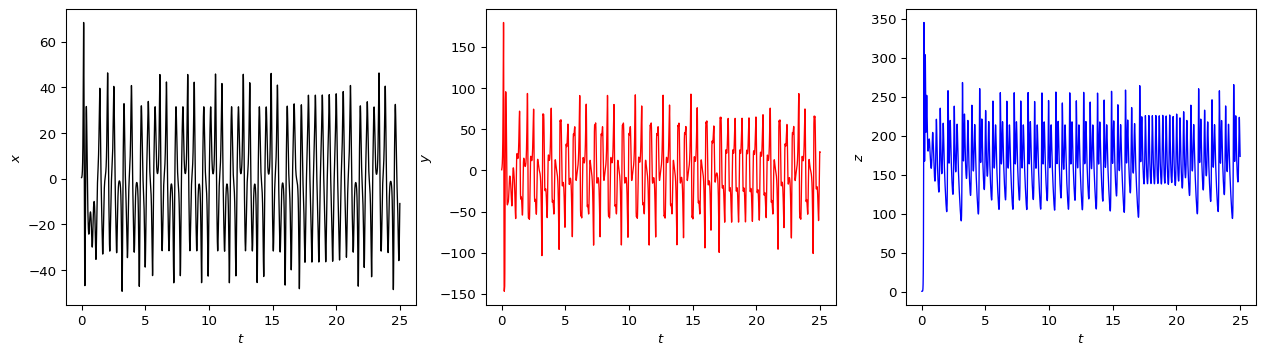

In [29]:
fig, axs = plt.subplots(1,3, figsize=(16,4), dpi = 96)
lim = 25000
axs[0].plot(t_eval[:lim], result_dict[0][0]['trajectories'][10][:lim,0], lw = 1, c = 'k')
axs[0].set_xlabel(r'$t$')
axs[0].set_ylabel(r'$x$')
axs[1].plot(t_eval[:lim], result_dict[0][0]['trajectories'][10][:lim,1], lw = 1, c = 'r')
axs[1].set_xlabel(r'$t$')
axs[1].set_ylabel(r'$y$')
axs[2].plot(t_eval[:lim], result_dict[0][0]['trajectories'][10][:lim,2], lw = 1, c = 'b')
axs[2].set_xlabel(r'$t$')
axs[2].set_ylabel(r'$z$')

plt.show()

In [233]:
def sample_trajectory(trajectories, Ttr, T_sample, n_samples, system_type='continuous'):
    """
    Samples points from the given trajectories based on the Julia logic.
    
    Parameters:
        trajectories (ndarray): Full trajectory data with shape (n_points, state_dim).
        Ttr (float): Transient time to exclude at the start.
        T_sample (float): Total sampling time.
        n_samples (int): Approximate number of samples to take.
        system_type (str): 'continuous' or 'discrete' for the system type.
        
    Returns:
        sampled_trajectory (ndarray): Array of sampled points.
    """
    assert system_type in {'continuous', 'discrete'}, "Invalid system type. Choose 'continuous' or 'discrete'."
    
    # Remove transient points
    transient_points = int(Ttr / T_sample * len(trajectories))
    
    trajectories = trajectories[transient_points:]
    
    if system_type == 'continuous':
        # Exponential sampling for continuous systems
        beta = T_sample / n_samples
        inter_sample_times = expon(scale=beta).rvs(size=n_samples)
    else:
        # Geometric sampling for discrete systems
        p = n_samples / T_sample
        inter_sample_times = geom(p).rvs(size=n_samples)
    
    # Ensure sampling times are valid indices
    inter_sample_indices = np.cumsum(inter_sample_times).astype(int)
    inter_sample_indices = inter_sample_indices[inter_sample_indices < len(trajectories)]
    
    # Sample the trajectory
    sampled_trajectory = trajectories[inter_sample_indices]
    
    return sampled_trajectory

def compute_lyapunov_exponent_ode(dynamics, 
                                  initial_state: np.ndarray, 
                                  t_span: np.ndarray, 
                                  initial_points: int =None,
                                  perturbation: float = 1e-8, 
                                  d_tol:float = 1e-3,
                                  std_tol = 0.4):
    """
    Compute the largest Lyapunov exponent by evolving perturbed states with the system dynamics.
    
    Parameters:
        dynamics (callable): Function defining the system's dynamics `dx/dt = f(x, t)`.
        initial_state (ndarray): Initial state of the system.
        t_span (ndarray): Array of time points for integration.
        initial_points (int): Number of initial points for slope estimation.
        perturbation (float): Initial perturbation distance (delta).
        d_tol (float): Tolerance distance for Lyapunov prediction time.
        std_tol (float): Tolerance standard deviation for Lyapunov prediction time.
    
    Returns:
        lambda_max (float): Largest Lyapunov exponent.
        T_lambda (float): Lyapunov prediction time.
    """
    if initial_points:
        assert initial_points < len(t_span), "The initial points for slope estimation has to be smaller than the time span"
    # Evolve the original trajectory
    trajectory = odeint(dynamics, initial_state, t_span)

    # Initialize a perturbed state
    perturbed_state = initial_state + perturbation * np.random.normal(size=len(initial_state))

    # Evolve the perturbed trajectory
    perturbed_trajectory = odeint(dynamics, perturbed_state, t_span)

    # Compute the distance between the trajectories at each time step
    distances = np.linalg.norm(trajectory - perturbed_trajectory, axis=1)
    
    # Avoid log of zero by filtering out invalid distances
    valid_indices = distances > 0
    log_distances = np.log(distances[valid_indices])
    time_points = t_span[valid_indices]
    
    if initial_points is None:
        start = 0
        stop = 1000
        step = 1000
        std_tol_tmp = np.inf

        while std_tol_tmp >= std_tol and stop <= len(log_distances):
            std_tol_tmp = np.std(log_distances[start:stop])
            start = stop
            stop += step
        initial_points = start
    # Fit a linear regression to the log of distances
    if len(log_distances) > 1:
        lambda_max = np.polyfit(time_points[:initial_points], log_distances[:initial_points], 1)[0]
    else:
        raise ValueError("Insufficient data points for Lyapunov exponent calculation.")

    # Compute the Lyapunov prediction time
    if lambda_max > 0:
        T_lambda = np.log(d_tol / perturbation) / lambda_max
    else:
        T_lambda = np.inf  # Regular system
    
    return lambda_max, T_lambda

In [184]:
def lorenz(x, t, sigma=10, rho=180.68, beta=8/3):
    dx = sigma * (x[1] - x[0])
    dy = x[0] * (rho - x[2]) - x[1]
    dz = x[0] * x[1] - beta * x[2]
    return [dx, dy, dz]

initial_state = [1.0, 1.0, 1.0]

lambda_max, T_lambda = compute_lyapunov_exponent_ode(
    lambda x, t: lorenz(x, t), initial_state, t_eval, std_tol=0.4
)
print(f"Largest Lyapunov Exponent (λ_max): {lambda_max}")
print(f"Lyapunov Prediction Time (T_λ): {T_lambda}")

Largest Lyapunov Exponent (λ_max): 1.671903576746153
Lyapunov Prediction Time (T_λ): 6.886118090240948


In [169]:
sample_trajectory(result_dict[0][0]['trajectories'][10],
                  200, 250, 500)

array([[-3.28127113e-02, -3.26149194e+01,  1.60030428e+02],
       [-3.28127113e-02, -3.26149194e+01,  1.60030428e+02],
       [-3.56862228e-01, -3.25863880e+01,  1.59610603e+02],
       ...,
       [-4.82069737e+00,  8.72626933e+00,  1.53778493e+02],
       [-4.82069737e+00,  8.72626933e+00,  1.53778493e+02],
       [-4.55517129e+00,  8.45336700e+00,  1.52880213e+02]])

In [141]:
def lambda_rescale(reference_state, test_state, scaling_factor):
    """
    Rescale the distance between two states in a parallel dynamical system.
    
    Parameters:
        reference_state (ndarray): The reference trajectory state (u1).
        test_state (ndarray): The test trajectory state (u2).
        scaling_factor (float): The scaling factor to adjust the distance.
    
    Returns:
        ndarray: The rescaled test state.
    """
    return reference_state + (test_state - reference_state) / scaling_factor

def lyapunov_benettin(dynamics, initial_state, T, dt=1, Ttr=0, d0=1e-9, 
                           d0_lower=None, d0_upper=None, inittest=None, show_progress=False):
    """
    Calculate the maximum Lyapunov exponent using the Benettin method with rescaling.
    
    Parameters:
        dynamics (callable): Function defining the system's dynamics `dx/dt = f(x, t)`.
        initial_state (ndarray): Initial state of the system.
        T (float): Total time for the calculation.
        dt (float): Time step for integration.
        Ttr (float): Transient time before measurement starts.
        d0 (float): Initial and rescaling distance between trajectories.
        d0_lower (float): Lower threshold for distance rescaling (default: 1e-3 * d0).
        d0_upper (float): Upper threshold for distance rescaling (default: 1e+3 * d0).
        inittest (callable): Custom initialization function for the test state.
                             Signature: `inittest(u1, d0) -> test_state`.
        show_progress (bool): Whether to show a progress bar.
    
    Returns:
        lyapunov_exponent (float): Largest Lyapunov exponent.
    """
    # Default thresholds for rescaling
    if d0_lower is None:
        d0_lower = 1e-3 * d0
    if d0_upper is None:
        d0_upper = 1e+3 * d0
    # assert Ttr < T "Transient time (Ttr) must be less than simulation time (T)"

    # Default initialization of test state
    if inittest is None:
        def inittest(u1, d0):
            return u1 + d0 / np.sqrt(len(u1)) * np.random.normal(size=len(u1))

    # Initialize reference and test trajectories
    reference_state = np.copy(initial_state)
    test_state = inittest(reference_state, d0)

    # Transient evolution
    if Ttr != 0:
        t_span = np.arange(0, Ttr, dt)
        reference_trajectory = odeint(dynamics, reference_state, t_span)
        test_trajectory = odeint(dynamics, test_state, t_span)
        reference_state = reference_trajectory[-1]
        test_state = test_trajectory[-1]

        distance = np.linalg.norm(reference_state - test_state)
        if distance < d0_lower or distance > d0_upper:
            test_state = lambda_rescale(reference_state, test_state, distance/d0)

    # Initialize variables for Lyapunov calculation
    total_time = 0
    lyapunov_sum = 0
    progress = tqdm(total=T, desc="Lyapunov Exponent Calculation", disable=not show_progress)
    distance = np.linalg.norm(reference_state - test_state)

    if distance < d0_lower or distance > d0_upper:
        raise ValueError(
            "After rescaling, the distance of reference and test states\n was not `d0_lower ≤ d ≤ d0_upper as expected.\n Perhaps you are using a dynamical system where the algorithm doesn't work."
            )
    if distance == 0:
        raise ValueError("The distance between reference and test states was 0 at the start.")
    # if 
        
    while total_time < T:
        while distance >= d0_lower and distance <= d0_upper:
            # Integrate for time step dt
            t_span = [0, dt]
            reference_trajectory = odeint(dynamics, reference_state, t_span)
            test_trajectory = odeint(dynamics, test_state, t_span)

            # Update states
            reference_state = reference_trajectory[-1]
            test_state = test_trajectory[-1]

            # Compute the distance between trajectories
            distance = np.linalg.norm(reference_state - test_state)
            if total_time > T:
                break
            total_time += dt
            progress.update(dt)

        distance = np.linalg.norm(reference_state - test_state)
        test_state = lambda_rescale(reference_state, test_state, distance/d0)
        # Accumulate the logarithm of the rescaling factor
        lyapunov_sum += np.log(distance / d0)

        # Update total time
        total_time += dt
        progress.update(dt)
    
    distance = np.linalg.norm(reference_state - test_state)
    scaling_factor = distance / d0
    test_state = reference_state + (test_state - reference_state) / scaling_factor

    # Accumulate the logarithm of the rescaling factor
    lyapunov_sum += np.log(distance / d0)

    progress.close()

    # Compute the Lyapunov exponent
    lyapunov_exponent = lyapunov_sum / T
    return lyapunov_exponent



In [170]:
# Example: Lorenz system
def lorenz(x, t, sigma=10, rho=180.68, beta=8/3):
    dx = sigma * (x[1] - x[0])
    dy = x[0] * (rho - x[2]) - x[1]
    dz = x[0] * x[1] - beta * x[2]
    return [dx, dy, dz]


In [171]:

# Initial conditions and parameters
initial_state = [1.0, 1.0, 1.0]
T = 500  # Total time
dt = 0.001
Ttr = 200

# Compute Lyapunov exponent
lyapunov_exponent = lyapunov_benettin(
    lambda x, t: lorenz(x, t), initial_state, T, dt=dt, Ttr=Ttr, show_progress=True
)
print(f"Maximum Lyapunov Exponent: {lyapunov_exponent}")


Lyapunov Exponent Calculation: 100%|█████████▉| 499.28099999510545/500 [00:41<00:00, 11.61it/s]/home/syntaxerror/.pyenv/versions/3.12.6/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Lyapunov Exponent Calculation: 100%|██████████| 500.0019999950884/500 [00:41<00:00, 11.96it/s] 

Maximum Lyapunov Exponent: 1.8069012066689987


In [158]:
def lyapunovspectrum(dynamics, jacobian, initial_state, 
                     N: int = 100000, 
                     k: int = 3, 
                     dt: float = 0.001, 
                     Ttr: int = 10, 
                     show_progress: bool = False):
    """
    Calculate the spectrum of Lyapunov exponents for a dynamical system using tangent dynamics.
    
    Parameters:
        dynamics (callable): Function defining the system's dynamics `dx/dt = f(x, t)`.
        jacobian (callable): Function computing the Jacobian matrix `df/dx` at a given state `x`.
        initial_state (ndarray): Initial state of the system.
        N (int): Number of samples for the Lyapunov spectrum.
        k (int): Number of exponents to compute.
        dt (float): Determines the time step
        Ttr (int): Transient time before measurement starts

    Returns:
        lyapunov_spectrum (ndarray): Spectrum of Lyapunov exponents.
    """
    state_dim = len(initial_state)
    if k is None:
        k = state_dim
    elif k > state_dim:
        raise ValueError("Number of exponents (k) cannot exceed system dimension.")

    # Initialize reference state and deviation vectors
    reference_state = np.copy(initial_state)
    deviations = np.eye(state_dim)[:, :k]  # Orthonormal basis for k directions
    lyapunov_sums = np.zeros(k)

    # Transient evolution
    if Ttr > 0:
        t_span = np.linspace(0, Ttr, int(Ttr / dt))
        reference_trajectory = odeint(dynamics, reference_state, t_span)
        reference_state = reference_trajectory[-1]

        # Evolve deviations during transient
        for _ in range(int(Ttr / dt)):
            deviations = evolve_tangent_dynamics(jacobian, reference_state, deviations, dt)
            deviations, _ = qr(deviations)

    # Main QR decomposition loop
    progress = tqdm(total=N, desc="Lyapunov spectrum", disable=not show_progress)
    for _ in range(N):
        # Step reference trajectory
        t_span = [0, dt]
        reference_trajectory = odeint(dynamics, reference_state, t_span)
        reference_state = reference_trajectory[-1]

        # Evolve deviation vectors using tangent dynamics
        deviations = evolve_tangent_dynamics(jacobian, reference_state, deviations, dt)

        # Perform QR decomposition
        deviations, r = qr(deviations)

        # Accumulate logarithms of the diagonal elements of R
        lyapunov_sums += np.log(np.abs(np.diag(r)))

        progress.update(1)
    progress.close()

    # Compute the Lyapunov exponents
    total_time = N * dt
    return lyapunov_sums / total_time

def evolve_tangent_dynamics(jacobian, reference_state, deviations, dt):
    """
    Evolve the deviation vectors using the tangent dynamics (Jacobian).
    """
    J = jacobian(reference_state)
    return deviations + dt * np.dot(J, deviations)


In [161]:
# Example: Lorenz system
def lorenz_dynamics(x, t):
    sigma, rho, beta = 10, 180.68, 8/3
    return np.array([
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    ])

def lorenz_jacobian(x):
    sigma, rho, beta = 10, 180.68, 8/3
    return np.array([
        [-sigma, sigma, 0],
        [rho - x[2], -1, -x[0]],
        [x[1], x[0], -beta]
    ])

# Initial conditions and parameters
initial_state = [1.0, 1.0, 1.0]
T = 500
dt = 0.001
Ttr = 200
N = 100000

# Compute the Lyapunov spectrum
lyapunov_exponents = lyapunovspectrum(
    lorenz_dynamics, lorenz_jacobian, initial_state, N, k=3, dt=dt, Ttr=Ttr, show_progress=True
)
print(f"Lyapunov Spectrum: {lyapunov_exponents}")


Lyapunov spectrum: 100%|██████████| 100000/100000 [00:09<00:00, 10560.44it/s]

Lyapunov Spectrum: [  1.75419828   0.40030336 -15.55010839]


In [470]:
def compute_distances_and_correlations(dynamics, 
                                       initial_conditions: np.ndarray, 
                                       delta_range: np.ndarray, 
                                       T: float, 
                                       d_tol: float, 
                                       lambda_max: float, 
                                       dt: float = 0.01,
                                       T_multiplier: float = 10):
    """
    Compute mean distances and cross-correlation for each delta in delta_range.
    
    Parameters:
        dynamics (callable): Function defining the system's dynamics `dx/dt = f(x, t)`.
        initial_conditions (ndarray): Array of sampled points from the system's trajectory.
        delta_range (ndarray): Array of perturbation distances.
        T (float): Maximum integration time for perturbations.
        d_tol (float): Distance tolerance used for scaling time.
        lambda_max (float): Largest Lyapunov exponent for the system.
        dt (float): Integration time step.
        T_multiplier (float): Multiplier for T to control the size of the perturbations.
    
    Returns:
        distances (list): Mean distances for each delta.
        correlations (list): Cross-correlations for each delta.
    """
    distances = []
    correlations = []

    # Calculate the variance of the sampled trajectory
    mu = np.mean(initial_conditions, axis=0)
    s2 = np.mean(np.linalg.norm(initial_conditions - mu, axis=1)**2)
    # s2 = np.mean([np.linalg.norm(x - mu)**2 for x in initial_conditions])
    # mu = np.mean(initial_conditions)
    # s2 = np.mean((initial_conditions - mu)**2)

    for delta in tqdm(delta_range, desc="Processing delta values"):
        T_lyap = np.log(d_tol / delta) / lambda_max  # Lyapunov prediction time
        evaluation_time = min(T, max(T_multiplier * T_lyap, 200))

        mean_distance = 0
        mean_square_distance = 0

        for u in initial_conditions:
            # Perturb the initial condition
            n = np.random.normal(size=u.shape)
            n /= np.linalg.norm(n)  # Normalize to unit vector
            perturbed_u = u + delta * n

            # Integrate both trajectories
            t_span = np.arange(0, evaluation_time, dt)
            reference_trajectory = odeint(dynamics, u, t_span)
            perturbed_trajectory = odeint(dynamics, perturbed_u, t_span)

            # Calculate the distance and accumulate
            final_reference = reference_trajectory[-1]
            final_perturbed = perturbed_trajectory[-1]
            distance = np.linalg.norm(final_reference - final_perturbed)
            mean_distance += distance
            mean_square_distance += distance**2

        # Calculate mean distance and correlation
        mean_distance /= len(initial_conditions)
        mean_square_distance /= len(initial_conditions)
        correlation = 1 - mean_square_distance / (2 * s2)

        distances.append(mean_distance)
        correlations.append(correlation)

    return distances, correlations

def compute_distance(dynamics, u, delta, evaluation_time, dt):
    # Perturb the initial condition
    n = np.random.normal(size=u.shape)
    n /= np.linalg.norm(n)  # Normalize to unit vector
    perturbed_u = u + delta * n

    # Integrate both trajectories
    t_span = np.arange(0, evaluation_time, dt)
    reference_trajectory = odeint(dynamics, u, t_span)
    perturbed_trajectory = odeint(dynamics, perturbed_u, t_span)

    # Calculate the distance
    final_reference = reference_trajectory[-1]
    final_perturbed = perturbed_trajectory[-1]
    distance = np.linalg.norm(final_reference - final_perturbed)
    return distance, distance**2

def compute_distances_and_correlations_paral(dynamics, 
                                            initial_conditions: np.ndarray, 
                                            delta_range: np.ndarray, 
                                            T: float, 
                                            d_tol: float, 
                                            lambda_max: float, 
                                            dt: float = 0.01,
                                            T_multiplier: float = 10):
    """
    Compute mean distances and cross-correlation for each delta in delta_range.
    
    Parameters:
        dynamics (callable): Function defining the system's dynamics `dx/dt = f(x, t)`.
        initial_conditions (ndarray): Array of sampled points from the system's trajectory.
        delta_range (ndarray): Array of perturbation distances.
        T (float): Maximum integration time for perturbations.
        d_tol (float): Distance tolerance used for scaling time.
        lambda_max (float): Largest Lyapunov exponent for the system.
        dt (float): Integration time step.
        T_multiplier (float): Multiplier for T to control the size of the perturbations.
    
    Returns:
        distances (list): Mean distances for each delta.
        correlations (list): Cross-correlations for each delta.
    """
    distances = []
    correlations = []

    # Calculate the variance of the sampled trajectory
    mu = np.mean(initial_conditions, axis=0)
    s2 = np.mean(np.linalg.norm(initial_conditions - mu, axis=1)**2)
    # s2 = np.mean([np.linalg.norm(x - mu)**2 for x in initial_conditions])
    # mu = np.mean(initial_conditions)
    # s2 = np.mean((initial_conditions - mu)**2)

    for delta in tqdm(delta_range, desc="Processing delta values"):
        T_lyap = np.log(d_tol / delta) / lambda_max  # Lyapunov prediction time
        evaluation_time = min(T, max(T_multiplier * T_lyap, 200))
        mean_distance = 0
        mean_square_distance = 0

        with ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(compute_distance, dynamics, u, delta, evaluation_time, dt)
                for u in initial_conditions
            ]
            for future in as_completed(futures):
                try:
                    distance, square_distance = future.result()
                    mean_distance += distance
                    mean_square_distance += square_distance
                except Exception as e:
                    print(f"Error computing distance: {e}")

        # Calculate mean distance and correlation
        mean_distance /= len(initial_conditions)
        mean_square_distance /= len(initial_conditions)
        correlation = 1 - mean_square_distance / (2 * s2)

        distances.append(mean_distance)
        correlations.append(correlation)

    return distances, correlations

def log_log_model(delta, nu, const, shift):
    """
    Log-log model function for cross-distance correlation

    Parameters:
        delta (float): Perturbation distance.
        nu (float): Scaling exponent.
        const (float): Constant term.
        c (float): Shift term.

    Returns:
        float: Log-log model function value.
    """
    return const*delta**nu + shift


def compute_distance_slope(delta_range, distances):
    """
    Compute the slope of distances in log-log space.

    Parameters:
        delta_range (ndarray): Array of perturbation distances.
        distances (list): Mean distances corresponding to each delta.

    Returns:
        slope (float): Scaling coefficient (nu).
    """
    popt, _ = curve_fit(log_log_model, delta_range, distances, p0=[0.001,5, 1], bounds=([0,0,0],[1, np.inf, np.inf]))
    slope, const, shift = popt

    return slope


In [481]:
# Define parameters

initial_state = [1.0, 1.0, 1.0]
T = 500  # Total time
dt = 0.001
Ttr = 200

T_sample = 500
n_samples = 100
delta_range = 10.0 ** np.arange(-9, -2.5, 0.5)
d_tol = 1e-3
T_multiplier = 10
T_max = 200

r_idx = 180

# Sample trajectories
initial_conditions = sample_trajectory(result_dict[0][0]['trajectories'][r_idx], Ttr=200, T_sample=T_sample, n_samples=n_samples)


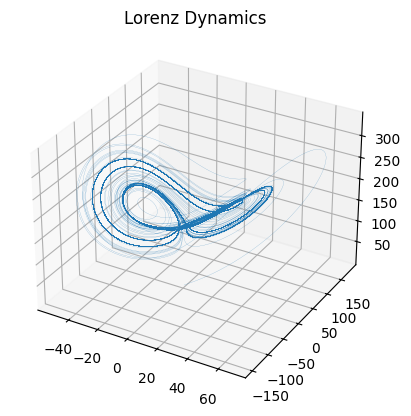

In [482]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(result_dict[0][0]['trajectories'][r_idx][:, 0], 
        result_dict[0][0]['trajectories'][r_idx][:, 1], 
        result_dict[0][0]['trajectories'][r_idx][:, 2],
        lw = 0.1)
plt.title("Lorenz Dynamics")
plt.show()


In [484]:
r_values[r_idx], delta_range, r_values[120]

(181.16250000000204,
 array([1.00000000e-09, 3.16227766e-09, 1.00000000e-08, 3.16227766e-08,
        1.00000000e-07, 3.16227766e-07, 1.00000000e-06, 3.16227766e-06,
        1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
        1.00000000e-03]),
 180.97500000000136)

In [485]:
def lorenz(x, t, sigma=10, rho=r_values[r_idx], beta=8/3):
    dx = sigma * (x[1] - x[0])
    dy = x[0] * (rho - x[2]) - x[1]
    dz = x[0] * x[1] - beta * x[2]
    return [dx, dy, dz]

# Benettin algorithm

# # Function to compute the Lyapunov exponent for a single initial condition
# def compute_lyapunov_exponent(initial_condition):
#     return lyapunov_benettin(lambda x, t: lorenz(x, t), initial_condition, T, dt=dt, Ttr=Ttr, show_progress=False)

# # Parallel computation
# lambd_maxes = []
# with ProcessPoolExecutor() as executor:
#     futures = {executor.submit(compute_lyapunov_exponent, ic): ic for ic in initial_conditions}
#     for future in tqdm(as_completed(futures), total=len(initial_conditions)):
#         try:
#             lambd_maxes.append(future.result())
#         except Exception as e:
#             print(f"Error computing Lyapunov exponent: {e}")

# # Compute the mean of the largest Lyapunov exponents
# lambd_max = np.mean(lambd_maxes)
# print(f"Largest Lyapunov Exponent: {lambd_max}")

# Extracting lambd_max from slope

def compute_lyapunov(initial_state):
    lambda_max, T_lambda = compute_lyapunov_exponent_ode(
        lambda x, t: lorenz(x, t), initial_state, t_eval, std_tol=0.4
    )
    return lambda_max, T_lambda

# Parallel computation
results = []
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(compute_lyapunov, state): state for state in initial_conditions}
    for future in tqdm(as_completed(futures), total=len(initial_conditions)):
        try:
            results.append(future.result())
        except Exception as e:
            print(f"Error computing Lyapunov exponent: {e}")

# Post-process results
lambda_maxes = [result[0] for result in results if result]
T_lambdas = [result[1] for result in results if result]

# Compute the mean values
lambda_max_mean = np.mean(lambda_maxes)
T_lambda_mean = np.mean(T_lambdas)

print(f"Average Largest Lyapunov Exponent (λ_max): {lambda_max_mean}")
print(f"Average Lyapunov Prediction Time (T_λ): {T_lambda_mean}")

# Compute distances and correlations
distances, correlations = compute_distances_and_correlations_paral(
    lorenz, initial_conditions, delta_range, T_max, d_tol, lambda_max_mean, dt
)

# Compute distance slope
nu = compute_distance_slope(delta_range, distances)
C = np.mean(correlations)

# Classify the system
if nu > 0.5 and C > 0.5:
    chaos_type = "REG"  # Regular
elif nu <= 0.5 and C > 0.5:
    chaos_type = "PPC"  # Partially Predictable Chaos
elif nu <= 0.5 and C <= 0.5:
    chaos_type = "SC"  # Strongly Chaotic
else:
    chaos_type = "IND"  # Indeterminate

print(f"Chaos Type: {chaos_type}, nu: {nu}, C: {C}")

100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Average Largest Lyapunov Exponent (λ_max): 0.024090798538091752
Average Lyapunov Prediction Time (T_λ): inf


Processing delta values: 100%|██████████| 13/13 [02:51<00:00, 13.22s/it]

Chaos Type: REG, nu: 0.999992615947569, C: 0.999999999829103


In [450]:
from sklearn.linear_model import LinearRegression
# Create a linear regression model
linear_model = LinearRegression()
linear_model.fit(np.log(delta_range).reshape(-1, 1), np.log(distances).reshape(-1, 1))

LinearRegression()

In [451]:
linear_model.coef_

array([[-0.0006999]])

In [469]:
def log_log_model(delta, nu, const, c):
    return const*delta**nu + c

popt, _ = curve_fit(log_log_model, delta_range, distances, p0=[0.01,5, 1], bounds=([0,0,0],[1, np.inf, np.inf]))
nu, const, c = popt

In [468]:
nu, const, c

(6.770103426607449e-06, 7.737190769240368e-07, 72.9356327789096)

In [454]:
linear_model.coef_

array([[-0.0006999]])

In [462]:
delta_range, np.std(distances), np.mean(distances), min(distances), max(distances), abs((min(distances)-max(distances)))/2

(array([1.00000000e-09, 3.16227766e-09, 1.00000000e-08, 3.16227766e-08,
        1.00000000e-07, 3.16227766e-07, 1.00000000e-06, 3.16227766e-06,
        1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
        1.00000000e-03]),
 1.3413477898483108,
 72.93563519292535,
 70.68125072991616,
 75.10957370060218,
 2.2141614853430127)

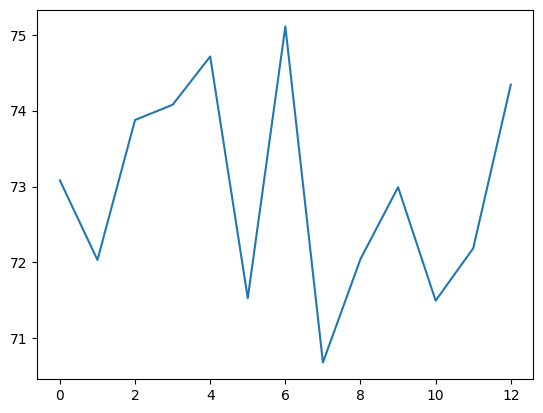

In [458]:
plt.plot(distances)
# plt.plot(delta_range, log_log_model(delta_range, nu, const, c))

In [196]:
linregress(np.log(delta_range), np.log(distances))

LinregressResult(slope=-0.305538896394446, intercept=-2.6848838093770495, rvalue=-0.9653224167080743, pvalue=0.16814447911188388, stderr=0.0826295580292399, intercept_stderr=1.529999736786378)

In [9]:
def cross_correlation_3d_jit(x1, x2, crs = None):
        """
        Compute the cross-correlation function C12(t) for two 3D trajectories x1(t) and x2(t),
        optimized with Numba for performance.

        Parameters:
            x1 (ndarray): Trajectory 1 (NxM array, where N is the number of time steps).
            x2 (ndarray): Trajectory 2 (NxM array, where N is the number of time steps).

        Returns:
            float: Cross-correlation value C12(t) across all dimensions.
        """
        # Ensure the trajectories have the same shape
        if x1.shape != x2.shape:
            raise ValueError("Trajectories x1 and x2 must have the same shape")
        
        # Calculate means and standard deviations along each dimension
        mu1 = np.mean(x1, axis=0)  # Mean for x1 (3 values)
        mu2 = np.mean(x2, axis=0)  # Mean for x2 (3 values)
        s1 = np.std(x1, axis=0)    # Standard deviation for x1 (3 values)
        s2 = np.std(x2, axis=0)    # Standard deviation for x2 (3 values)
        
        # Compute deviations and cross-correlation for all dimensions
        delta_x1 = x1 - mu1
        delta_x2 = x2 - mu1
        cross_corr = delta_x1 * delta_x2 / (s1 * s1)
        cross_corr /= cross_corr.max(axis = 0)
        
        # Return the average cross-correlation across all dimensions
        if crs is not None:
            cross_corr += crs
        return cross_corr